### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the Data

In [2]:
train = pd.read_csv('mnist_train.csv')
target = pd.read_csv('mnist_train_targets.csv')
test = pd.read_csv('mnist_test.csv')

### Exploratory Analysis

#### Convert DataFrame into Arrays

In [3]:
train = np.array(train)


In [4]:
target  = np.array(target)

In [5]:
test = np.array(test)

#### Check the Shape of Dataset

In [6]:
train.shape

(784, 60000)

In [7]:
target.shape

(60000, 1)

In [8]:
test.shape

(784, 10000)

#### Visualizing the First 25 Digits

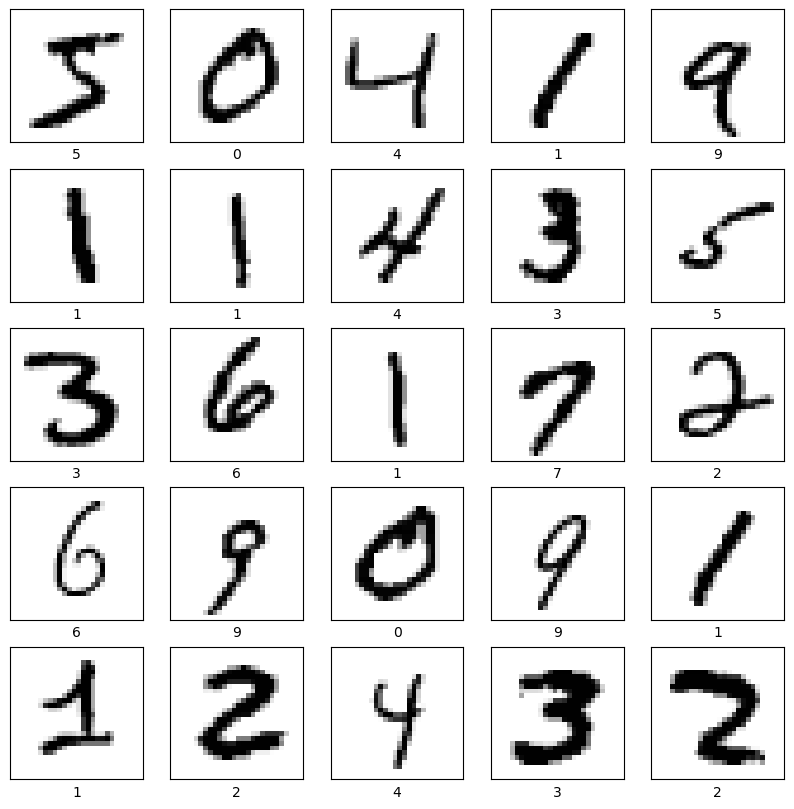

In [51]:
train_plt = train.T

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Reshape each row into 28x28 image for display
    plt.imshow(train_plt[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(target[i][0])
plt.show()

#### Visulizing the Disribution of Digits in the Training Data

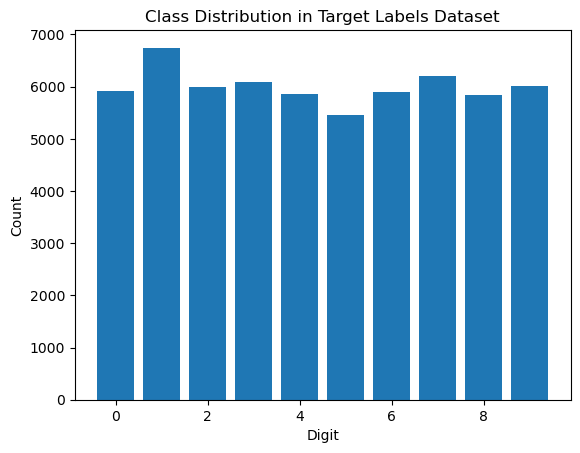

In [31]:
unique, counts = np.unique(target, return_counts=True)
plt.bar(unique, counts)
plt.title('Class Distribution in Target Labels Dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()


#### Pixel Range, Mean and Standard Deviation

In [46]:
print(f'Pixel values range from {train_plt.min()} to {train_plt.max()}')
mean = np.mean(train_plt)
std_dev = np.std(train_plt)
print(f'Mean: {mean}')
print(f'Standard Deviation: {std_dev}')

Pixel values range from 0 to 255
Mean: 33.3938693877551
Standard Deviation: 78.662943924569


### Normalizing the data

In [9]:
train = np.apply_along_axis(lambda y: y / 255, axis=0, arr=train)
test = np.apply_along_axis(lambda y: y / 255, axis=0, arr=test)

In [29]:
print(f'Pixel values range from {train.min()} to {train.max()}')
mean = np.mean(train)
std_dev = np.std(train)
print(f'Mean: {mean}')
print(f'Standard Deviation: {std_dev}')

Pixel values range from 0.0 to 1.0
Mean: 0.13095635054021634
Standard Deviation: 0.30848213303752536


After normalizing the data, the range of our pixel is  between 0 and 1, a mean of 0.13 and standard deviatio of 0.30. These statistics  are much better than the original range of 0 - 255, mean of 33, and  standard deviation of 78. We are more likely to achieve convergence faster and have reduced computational complexity with the normalized data.

## Building A Neural Network from Scratch

#### Defining Activation and Loss Functions

In [10]:
def relu(z):
    return np.maximum(0, z)

def relu_prime(z):
    return (z > 0).astype(float)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m
    return loss

def cross_entropy_prime(y_pred, y_true):
    return y_pred - y_true

def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

#### Multilayer Perceptron with Forward Propagation, Backward Propagation, and Weight Updates
##### Using ReLU and Softmax Activation Function and Cross Entropy Loss for Backward Propagation

In [11]:
def multilayer_perceptron(x, y, epochs, learning_rate, h1, h2, num_classes):
    w1 = np.random.randn(x.shape[1], h1) / np.sqrt(x.shape[1] / 2.)
    b1 = np.zeros(h1)
    w2 = np.random.randn(h1, h2) / np.sqrt(h1 / 2.)
    b2 = np.zeros(h2)
    w3 = np.random.randn(h2, num_classes) / np.sqrt(h2 / 2.)
    b3 = np.zeros(num_classes)

    y_one_hot = one_hot_encode(y, num_classes)

    for epoch in range(epochs):
        # Forward pass
        z1 = np.dot(x, w1) + b1
        a1 = relu(z1)
        z2 = np.dot(a1, w2) + b2
        a2 = relu(z2)
        z3 = np.dot(a2, w3) + b3
        a3 = softmax(z3)

        loss = cross_entropy_loss(a3, y_one_hot)
        #print(f'Epoch {epoch}, loss: {loss}')

        # Backward pass
        delta3 = cross_entropy_prime(a3, y_one_hot)
        delta2 = np.dot(delta3, w3.T) * relu_prime(a2)
        delta1 = np.dot(delta2, w2.T) * relu_prime(a1)

        # Update weights and biases
        w3 -= learning_rate * np.dot(a2.T, delta3)
        b3 -= learning_rate * np.sum(delta3, axis=0)
        w2 -= learning_rate * np.dot(a1.T, delta2)
        b2 -= learning_rate * np.sum(delta2, axis=0)
        w1 -= learning_rate * np.dot(x.T, delta1)
        b1 -= learning_rate * np.sum(delta1, axis=0)

    return w1, b1, w2, b2, w3, b3


In [ ]:
In this section, I defined a multilayer perceptron with 2 hidden layers. 
The first section intialized  weights and  biases for the  model using Glorot Initialization. Glorot initalization is much better than random intialization since it helps to protect from vanishing or exploding gradients.
The second  section  initialized a loop that did  forward propagation using relu and softmax, calculated the loss, and did back propagation while updating the weights and biases.
The results of this  function were the  final  weights and biases used in the neural network.

#### Fitting our Data in the Model

In [13]:
x = train.T
y = target
w1, b1, w2, b2, w3, b3 = multilayer_perceptron(x, y, 20, 0.0001, 50, 25, 10)

C:\Users\Ian\AppData\Local\Temp\ipykernel_5408\3685735863.py:8: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))


#### Predicting the Values for our Test Data

In [16]:
def predict(X, w1, b1, w2, b2, w3, b3):
    # Forward pass
    z1 = np.dot(X, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = relu(z2)
    z3 = np.dot(a2, w3) + b3
    a3 = softmax(z3)

    # Predicted class is the one with the highest probability
    predictions = np.argmax(a3, axis=1)
    return predictions

# Example usage
X_test_preprocessed = test.T  
predictions = predict(X_test_preprocessed, w1, b1, w2, b2, w3, b3)





## Building Model Using Pytorch

In [21]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


### Defining the Pytorch

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)  
        self.fc2 = nn.Linear(128, 64)   
        self.fc3 = nn.Linear(64, 32)    
        self.fc4 = nn.Linear(32, 10)    

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)  
        return x

net = Net()


In [ ]:
# 784 input features, 128 output features
# 64 output features from the second hidden layer
# 32 output features from the third hidden layer
# 10 output features for 10 classes of MNIST
# No activation, this is raw output, softmax is applied in the loss functi

### Converting the Data into PyTorch Tensor and Loading it  into the Model

In [21]:
train = train.T
target = target.squeeze()
# Convert train data to PyTorch tensor
train_tensor = torch.Tensor(train)  
# Convert target data to PyTorch tensor and transforming the value to class indices
target_tensor = torch.tensor(target, dtype=torch.long)

# Create a dataset and a data loader
train_dataset = TensorDataset(train_tensor, target_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


### Training the Dataset

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

for epoch in range(10):  
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}')





Epoch 1, loss: 1.0357391570549783
Epoch 2, loss: 0.3722978920570569
Epoch 3, loss: 0.29417386929045863
Epoch 4, loss: 0.2519475618945256
Epoch 5, loss: 0.22322526273093243
Epoch 6, loss: 0.19990022752934428
Epoch 7, loss: 0.18187645541976638
Epoch 8, loss: 0.16800345819213117
Epoch 9, loss: 0.1554920194126459
Epoch 10, loss: 0.14450318917536786


### Predicting Values for the Test Data

In [23]:
# Convert test to PyTorch tensor
X_test_tensor = torch.Tensor(test.T)  

# Set the model to evaluation mode
net.eval()

# Make predictions
with torch.no_grad():
    outputs = net(X_test_tensor)
    _, predictions = torch.max(outputs, 1)


### Cross Validation and Hyperparameter Tuning

#### Splitting the Data into 80-20 sets

In [24]:
print(train.shape)
print(type(train))

(60000, 784)
<class 'numpy.ndarray'>


In [25]:
print(target.shape)
print(type(target))

(60000,)
<class 'numpy.ndarray'>


In [26]:
from sklearn.model_selection import train_test_split

# Splitting the data into 80-20
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

#### Cross Validation and Hypeparameter Tuning

In [27]:
def calculate_accuracy(predictions, y_true):
    correct_predictions = np.sum(predictions == y_true)
    accuracy = correct_predictions / len(y_true)
    return accuracy

def validate_hyperparameters(X_train, y_train, X_test, y_test, epochs_list, learning_rate_list, h1_list, h2_list, num_classes):
    for epochs in epochs_list:
        for learning_rate in learning_rate_list:
            for h1 in h1_list:
                for h2 in h2_list:
                    # Train the model
                    w1, b1, w2, b2, w3, b3 = multilayer_perceptron(X_train, y_train, epochs, learning_rate, h1, h2, num_classes)

                    # Make predictions on the test set
                    predictions = predict(X_test, w1, b1, w2, b2, w3, b3)

                    # Calculate accuracy
                    accuracy = calculate_accuracy(predictions, y_test)

                    print(f'Epochs: {epochs}, Learning Rate: {learning_rate}, h1: {h1}, h2: {h2}, Accuracy: {accuracy:.2f}')


# Defining Lists of hyperparameters
epoch_list = [7, 14, 21]
learning_rate_list = [0.01, 0.001, 0.0001]
h1_list = [32, 64, 128]
h2_list = [12, 25, 50]
# We have only ten classes from 0-9
num_classes = 10  

# Calling the function
validate_hyperparameters(X_train, y_train, X_test, y_test, epoch_list, learning_rate_list, h1_list, h2_list, num_classes)


Epochs: 7, Learning Rate: 0.01, h1: 32, h2: 12, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 32, h2: 25, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 32, h2: 50, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 64, h2: 12, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 64, h2: 25, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 64, h2: 50, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 128, h2: 12, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 128, h2: 25, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.01, h1: 128, h2: 50, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 32, h2: 12, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 32, h2: 25, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 32, h2: 50, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 64, h2: 12, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 64, h2: 25, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 64, h2: 50, Accuracy: 0.10
Epochs: 7, Learning Rate: 0.001, h1: 128, h2: 

### Converting Predictions into Submission Format

In [28]:
# Create a DataFrame from the Predictions
## The output of both models are named similary despite being two different object types 
submission_df = pd.DataFrame({
    "Id": range(1, 10001), 
    "Expected": predictions
})

# Write the DataFrame to a CSV file
submission_df.to_csv("submission101.csv", index=False)